In [80]:
import gc, os
# import cudf
# import talib as ta
import numpy as np
import pandas as pd
# import jpx_tokyo_market_prediction
import matplotlib.pyplot as plt


from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [81]:
%matplotlib inline

In [7]:
# train = pd.read_csv('../Input/train_files/stock_prices.csv')

In [8]:
# del train

In [9]:
# supplemental_train = pd.read_csv('../Input/supplemental_files/stock_prices.csv')

In [16]:
# del supplemental_train

In [3]:
# train.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target'],
      dtype='object')

In [10]:
print(supplemental_train.Date.unique().min())
print(supplemental_train.Date.unique().max())

2021-12-06
2022-02-28


In [87]:
X = pd.read_parquet('../Output/train_scaling.parquet')

In [89]:
[c for c in X.columns]

['RowId',
 'Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'AdjustmentFactor',
 'ExpectedDividend',
 'SupervisionFlag',
 'Target',
 'Section/Products',
 'NewMarketSegment',
 '33SectorCode',
 '17SectorCode',
 'NewIndexSeriesSizeCode',
 'Universe0',
 'day',
 'weekday',
 'week',
 'month',
 'high_rank',
 'CumulativeAdjustmentFactor',
 'AdjustedOpen',
 'AdjustedHigh',
 'AdjustedLow',
 'AdjustedClose',
 'ror_1',
 'ror_2',
 'ror_3',
 'ror_4',
 'ror_5',
 'ror_6',
 'ror_7',
 'ror_8',
 'ror_9',
 'ror_10',
 'ror_20',
 'ror_40',
 'ror_60',
 'ror_100',
 'TradedAmount',
 'TradedAmount_1',
 'TradedAmount_5',
 'TradedAmount_10',
 'TradedAmount_20',
 'TradedAmount_40',
 'TradedAmount_60',
 'TradedAmount_100',
 'd_Amount',
 'PreviousClose',
 'range',
 'range_1',
 'range_5',
 'range_10',
 'range_20',
 'range_40',
 'range_60',
 'range_100',
 'd_atr',
 'gap_range',
 'gap_range_1',
 'gap_range_5',
 'gap_range_10',
 'gap_range_20',
 'gap_range_40',
 'gap_range_60',
 'gap_range_100',
 'day_range',
 'd

In [290]:
col_use = [
    'SecuritiesCode', #　証券番号
    'Date',
    'month',
    'day',
    'Volume',
    'Section/Products', # 東証一部、二部など
    'NewMarketSegment', # プライム、スタンダードなど
    '33SectorCode', # Glass and Ceramics Productsなどのセクターコード
    '17SectorCode', # CONSTRUCTION & MATERIALSなどのセクターコード
    'NewIndexSeriesSizeCode', # TOPIX SmallなどのTOPIXのIndexコード
    'AdjustedOpen',
    'AdjustedHigh',
    'AdjustedLow',
    'AdjustedClose',
    'ResultDividendPerShare1stQuarter',
    'ResultDividendPerShare2ndQuarter',
    'ResultDividendPerShare3rdQuarter',
    'ResultDividendPerShareFiscalYearEnd',
    'ResultDividendPerShareAnnual',
    'ForecastDividendPerShare1stQuarter',
    'ForecastDividendPerShare2ndQuarter',
    'ForecastDividendPerShare3rdQuarter',
    'ForecastDividendPerShareFiscalYearEnd',
    'ForecastDividendPerShareAnnual',
]

# col_use  = [
#     # 'day', 'Volume',
#     'ScaledAdjustedClose',
#     # 'close_arccos_deg',
#     'trend_psa_indicator',
#     'trend_aroon_ind_diff1',
#     # 'volume_pct_change_ror_1',
#     'sma_5_25', 'sma_25_30',
#     'd_atr',
#     'ror_1', 'ror_5', 'ror_10',
#     'TradedAmount_1', 'TradedAmount_5',
#     # 'ror1_ror2', 'ror1_ror3', 'ror1_ror4', 'ror1_ror5',
#     'ror_1_shift1', 'ror_1_shift2', 'ror_1_shift3', 'ror_1_shift4', 'ror_1_shift5',
#     'ror_1_shift6', 'ror_1_shift7', 'ror_1_shift8', 'ror_1_shift9',
#     'd_Amount',
#     'range_1', 'range_5',
#     'gap_range_1', 'gap_range_5',
#     'day_range_1', 'day_range_5',
#     'hig_range_1', 'hig_range_5',
#     'mi_1', 'mi_5',
#     'vola_10',
#     'hl_5', 'hl_10',
# ]

In [291]:
read_cols = col_use + ['Target']

In [292]:
X = pd.read_parquet('../Output/train_scaling.parquet', columns=read_cols)
# X = pd.read_parquet('../Output/train_scaling.parquet')

In [293]:
X['year'] = X['Date'].dt.year

In [294]:
X['date_str'] = X['Date'].astype(str)

In [295]:
X.dtypes

SecuritiesCode                                    int64
Date                                     datetime64[ns]
month                                             int64
day                                               int64
Volume                                            int64
Section/Products                                   int8
NewMarketSegment                                   int8
33SectorCode                                       int8
17SectorCode                                       int8
NewIndexSeriesSizeCode                             int8
AdjustedOpen                                    float64
AdjustedHigh                                    float64
AdjustedLow                                     float64
AdjustedClose                                   float64
ResultDividendPerShare1stQuarter                float64
ResultDividendPerShare2ndQuarter                float64
ResultDividendPerShare3rdQuarter                float64
ResultDividendPerShareFiscalYearEnd             

In [296]:
X.shape

(2286531, 27)

In [297]:
[c for c in X.columns]

['SecuritiesCode',
 'Date',
 'month',
 'day',
 'Volume',
 'Section/Products',
 'NewMarketSegment',
 '33SectorCode',
 '17SectorCode',
 'NewIndexSeriesSizeCode',
 'AdjustedOpen',
 'AdjustedHigh',
 'AdjustedLow',
 'AdjustedClose',
 'ResultDividendPerShare1stQuarter',
 'ResultDividendPerShare2ndQuarter',
 'ResultDividendPerShare3rdQuarter',
 'ResultDividendPerShareFiscalYearEnd',
 'ResultDividendPerShareAnnual',
 'ForecastDividendPerShare1stQuarter',
 'ForecastDividendPerShare2ndQuarter',
 'ForecastDividendPerShare3rdQuarter',
 'ForecastDividendPerShareFiscalYearEnd',
 'ForecastDividendPerShareAnnual',
 'Target',
 'year',
 'date_str']

In [298]:
# supplemental_train = pd.read_csv('../Input/train_files/secondary_stock_prices.csv')

In [299]:
# supplemental_train.head()

In [300]:
# supplemental_train.shape

In [301]:
def minmax(X):
    min = X.min(axis=0)
    max = X.max(axis=0)
    return  (X - min) / (max - min)

In [302]:
X.shape

(2286531, 27)

In [303]:
X.year.astype(str).unique()

array(['2017', '2018', '2019', '2020', '2021'], dtype=object)

In [304]:
X['date_str'] = X['Date'].astype(str)

In [306]:
target_cols = [
    'SecuritiesCode',
    'Date',
    'year',
    'AdjustedClose',
    'Section/Products',
    'NewMarketSegment', # プライム、スタンダードなど
    '33SectorCode', # Glass and Ceramics Productsなどのセクターコード
    '17SectorCode', # CONSTRUCTION & MATERIALSなどのセクターコード
    'NewIndexSeriesSizeCode', # TOPIX SmallなどのTOPIXのIndexコード
    'ResultDividendPerShare1stQuarter',
    'ResultDividendPerShare2ndQuarter',
    'ResultDividendPerShare3rdQuarter',
    'ResultDividendPerShareFiscalYearEnd',
    'ResultDividendPerShareAnnual',
    'ForecastDividendPerShare1stQuarter',
    'ForecastDividendPerShare2ndQuarter',
    'ForecastDividendPerShare3rdQuarter',
    'ForecastDividendPerShareFiscalYearEnd',
    'ForecastDividendPerShareAnnual',
]


In [307]:
def yearly_stock_price_change(X):
    year_range = X.year.astype(str).unique()
    start_end_years = [X[X['date_str'].str.contains(y)]['date_str'].agg([min, max]) for y in year_range]
    start_dates = [y['min'] for y in start_end_years]
    brand_list = [X[X['Date'] == date]['SecuritiesCode'].unique() for date in start_dates]
    df_list = []
    for i in range(len(year_range)):
        start_close_price = X[(X['SecuritiesCode'].isin(brand_list[i])) & (X['Date'] == start_end_years[i]['min'])][target_cols].reset_index(drop=True)
        end_close_price = X[(X['SecuritiesCode'].isin(brand_list[i])) & (X['Date'] == start_end_years[i]['max'])][target_cols].reset_index(drop=True)
        start_close_price['change_ratio'] = (end_close_price['AdjustedClose'] - start_close_price['AdjustedClose']) / start_close_price['AdjustedClose']
        df_list.append(start_close_price)

    return pd.concat(df_list)

In [308]:
df = yearly_stock_price_change(X)

In [309]:
df

,SecuritiesCode,Date,year,AdjustedClose,Section/Products,NewMarketSegment,33SectorCode,17SectorCode,NewIndexSeriesSizeCode,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,change_ratio
0,1301,2017-01-04,2017,2742.0,0,1,0,0,4,0.0,0.0,0.0,60.0,60.0,0.0,0.0,0.0,50.0,50.0,0.566375
1,1332,2017-01-04,2017,571.0,0,1,0,0,2,0.0,2.5,0.0,3.5,6.0,0.0,4.0,0.0,2.5,5.0,0.031524
2,1333,2017-01-04,2017,3210.0,0,1,0,0,2,0.0,0.0,0.0,45.0,45.0,0.0,0.0,0.0,30.0,30.0,0.059190
3,1376,2017-01-04,2017,1550.0,0,2,0,0,4,0.0,11.0,0.0,15.0,26.0,0.0,11.0,0.0,14.0,25.0,0.098065
4,1377,2017-01-04,2017,3330.0,0,1,0,0,3,0.0,10.0,0.0,18.0,28.0,0.0,10.0,0.0,13.0,23.0,0.174174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9990,2021-01-04,2021,530.0,0,1,26,13,4,0.0,0.0,0.0,30.0,30.0,0.0,0.0,0.0,30.0,30.0,0.039623
1996,9991,2021-01-04,2021,959.0,0,1,25,12,4,0.0,15.0,0.0,20.0,35.0,0.0,15.0,0.0,20.0,35.0,-0.103233
1997,9993,2021-01-04,2021,1739.0,0,2,26,13,4,0.0,13.5,0.0,13.5,27.0,0.0,13.5,0.0,13.5,27.0,-0.010926
1998,9994,2021-01-04,2021,2130.0,0,2,26,13,4,0.0,24.0,0.0,23.0,46.0,0.0,24.0,0.0,24.0,48.0,0.129108


In [ ]:
df.groupby('33SectorCode')['SecuritiesCode'].sum()

33SectorCode
0       48770
1       39815
2      889903
3     1078172
4      398346
5      194280
6     3260455
7     1011216
8      217195
9      334805
10     779890
11     631325
12     599133
13     994153
14    4053271
15    5239684
16    1798905
17    1257805
18    1778039
19    1085361
20    1948057
21     319820
22     184340
23     744570
24    5528812
25    5202636
26    5392226
27    2571494
28     806037
29     442747
30    1015083
31    2058388
32    5041751
Name: SecuritiesCode, dtype: int64

In [310]:
stock_list = pd.read_csv('../Input/stock_list.csv')

In [311]:
dict_33SectorName = dict(zip(stock_list['SecuritiesCode'], stock_list['33SectorName']))
dict_17SectorName = dict(zip(stock_list['SecuritiesCode'], stock_list['17SectorName']))
dict_NewIndexSeriesSize = dict(zip(stock_list['SecuritiesCode'], stock_list['NewIndexSeriesSize']))
dict_NewMarketSegment = dict(zip(stock_list['SecuritiesCode'], stock_list['NewMarketSegment']))
dict_Section_Products = dict(zip(stock_list['SecuritiesCode'], stock_list['Section/Products']))

In [312]:
df['33SectorName'] = df['SecuritiesCode'].map(dict_33SectorName)
df['17SectorName'] = df['SecuritiesCode'].map(dict_17SectorName)
df['NewIndexSeriesSize'] = df['SecuritiesCode'].map(dict_NewIndexSeriesSize)
df['NewMarketSegment'] = df['SecuritiesCode'].map(dict_NewMarketSegment)
df['Section_Products'] = df['SecuritiesCode'].map(dict_Section_Products)

In [314]:
df

,SecuritiesCode,Date,year,AdjustedClose,Section/Products,NewMarketSegment,33SectorCode,17SectorCode,NewIndexSeriesSizeCode,ResultDividendPerShare1stQuarter,...,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,change_ratio,33SectorName,17SectorName,NewIndexSeriesSize,Section_Products
0,1301,2017-01-04,2017,2742.0,0,Prime Market,0,0,4,0.0,...,0.0,0.0,0.0,50.0,50.0,0.566375,"Fishery, Agriculture and Forestry",FOODS,TOPIX Small 2,First Section (Domestic)
1,1332,2017-01-04,2017,571.0,0,Prime Market,0,0,2,0.0,...,0.0,4.0,0.0,2.5,5.0,0.031524,"Fishery, Agriculture and Forestry",FOODS,TOPIX Mid400,First Section (Domestic)
2,1333,2017-01-04,2017,3210.0,0,Prime Market,0,0,2,0.0,...,0.0,0.0,0.0,30.0,30.0,0.059190,"Fishery, Agriculture and Forestry",FOODS,TOPIX Mid400,First Section (Domestic)
3,1376,2017-01-04,2017,1550.0,0,Standard Market,0,0,4,0.0,...,0.0,11.0,0.0,14.0,25.0,0.098065,"Fishery, Agriculture and Forestry",FOODS,TOPIX Small 2,First Section (Domestic)
4,1377,2017-01-04,2017,3330.0,0,Prime Market,0,0,3,0.0,...,0.0,10.0,0.0,13.0,23.0,0.174174,"Fishery, Agriculture and Forestry",FOODS,TOPIX Small 1,First Section (Domestic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9990,2021-01-04,2021,530.0,0,Prime Market,26,13,4,0.0,...,0.0,0.0,0.0,30.0,30.0,0.039623,Retail Trade,RETAIL TRADE,TOPIX Small 2,First Section (Domestic)
1996,9991,2021-01-04,2021,959.0,0,Prime Market,25,12,4,0.0,...,0.0,15.0,0.0,20.0,35.0,-0.103233,Wholesale Trade,COMMERCIAL & WHOLESALE TRADE,TOPIX Small 2,First Section (Domestic)
1997,9993,2021-01-04,2021,1739.0,0,Standard Market,26,13,4,0.0,...,0.0,13.5,0.0,13.5,27.0,-0.010926,Retail Trade,RETAIL TRADE,TOPIX Small 2,First Section (Domestic)
1998,9994,2021-01-04,2021,2130.0,0,Standard Market,26,13,4,0.0,...,0.0,24.0,0.0,24.0,48.0,0.129108,Retail Trade,RETAIL TRADE,TOPIX Small 2,First Section (Domestic)


In [315]:
def yearly_change_ratio_plot(df, col):
    year_df = df.groupby(['year', col])['change_ratio'].mean().reset_index()
    pivot_df = year_df.pivot(index='year', columns=col, values='change_ratio')
    pivot_df.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


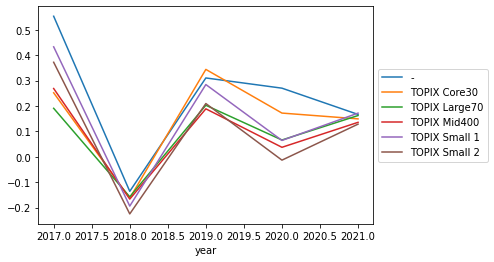

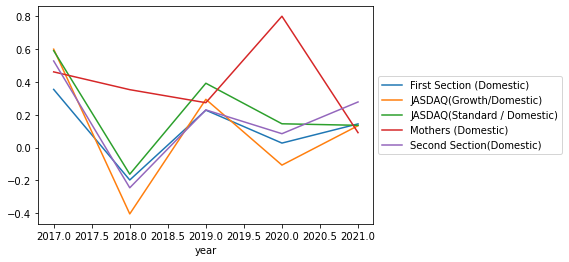

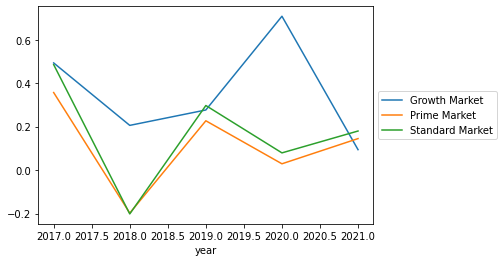

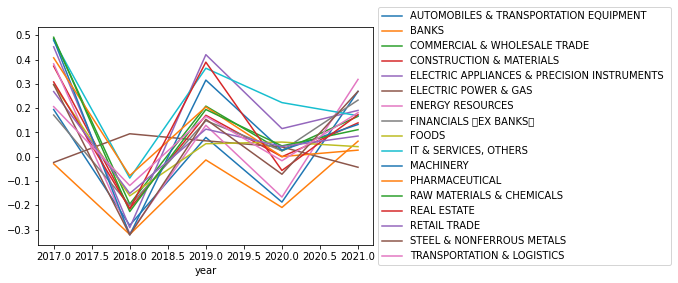

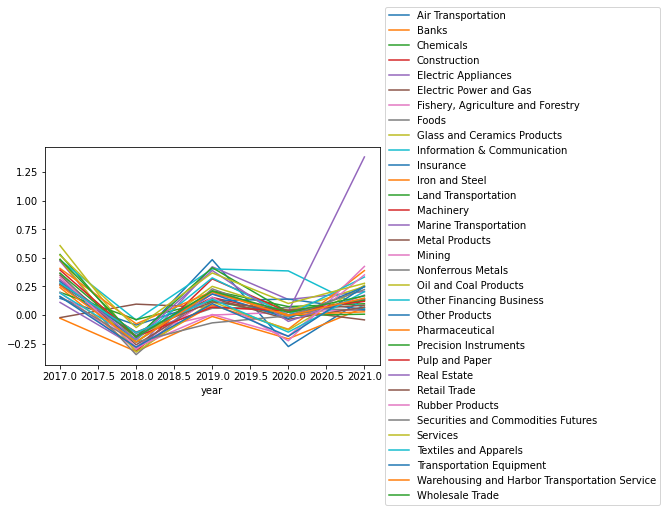

In [316]:
yearly_change_ratio_plot(df, 'NewIndexSeriesSize')
yearly_change_ratio_plot(df, 'Section_Products')
yearly_change_ratio_plot(df, 'NewMarketSegment')
yearly_change_ratio_plot(df, '17SectorName')
yearly_change_ratio_plot(df, '33SectorName')

In [317]:
SecuritiesCodeGroupVolume = X.groupby(['SecuritiesCode'])['Volume'].mean()

In [318]:
value_filetered_SecuritiesCode = SecuritiesCodeGroupVolume[SecuritiesCodeGroupVolume >= 100000].index

In [319]:
value_filetered_SecuritiesCode

Int64Index([1332, 1333, 1375, 1377, 1407, 1414, 1417, 1419, 1429, 1435,
            ...
            9928, 9945, 9948, 9956, 9962, 9983, 9984, 9987, 9989, 9997],
           dtype='int64', name='SecuritiesCode', length=1193)

In [320]:
filtered_df = df[df['SecuritiesCode'].isin(value_filetered_SecuritiesCode)]

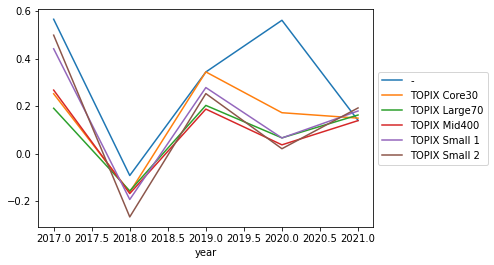

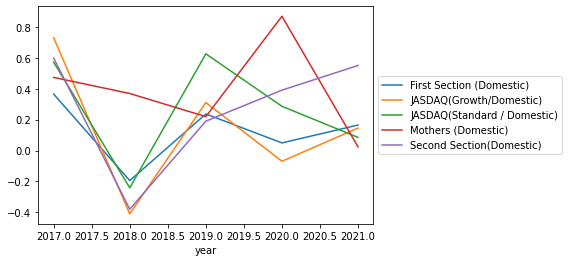

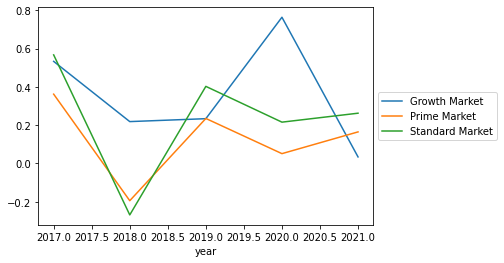

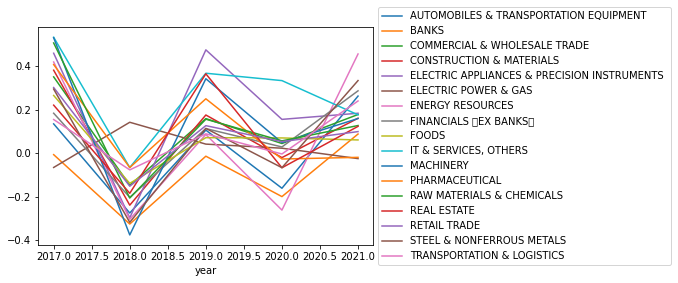

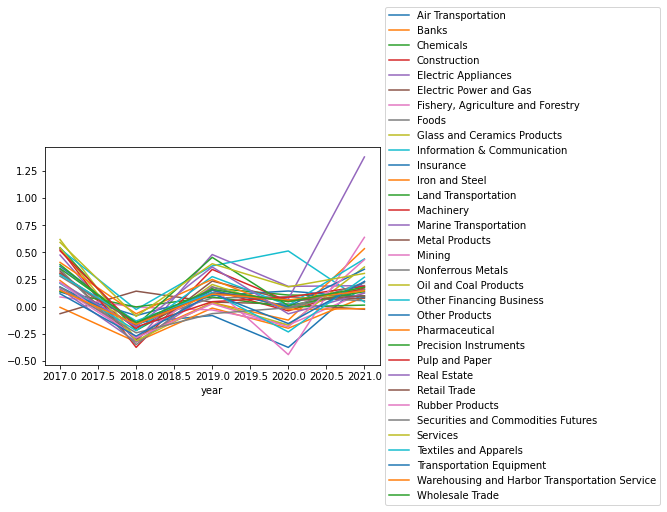

In [321]:
yearly_change_ratio_plot(filtered_df, 'NewIndexSeriesSize')
yearly_change_ratio_plot(filtered_df, 'Section_Products')
yearly_change_ratio_plot(filtered_df, 'NewMarketSegment')
yearly_change_ratio_plot(filtered_df, '17SectorName')
yearly_change_ratio_plot(filtered_df, '33SectorName')

In [327]:
filtered_df['ResultDividendPerShare1stQuarter/AdjustedClose'] = (filtered_df['ResultDividendPerShare1stQuarter'] * 100 / filtered_df['AdjustedClose']).round()
filtered_df['ResultDividendPerShare2ndQuarter/AdjustedClose'] = (filtered_df['ResultDividendPerShare2ndQuarter'] * 100 / filtered_df['AdjustedClose']).round()
filtered_df['ResultDividendPerShare3rdQuarter/AdjustedClose'] = (filtered_df['ResultDividendPerShare3rdQuarter'] * 100 / filtered_df['AdjustedClose']).round()
filtered_df['ResultDividendPerShareFiscalYearEnd/AdjustedClose'] = (filtered_df['ResultDividendPerShareFiscalYearEnd'] * 100 / filtered_df['AdjustedClose']).round()
filtered_df['ResultDividendPerShareAnnual/AdjustedClose'] = (filtered_df['ResultDividendPerShareAnnual'] * 100 / filtered_df['AdjustedClose']).round()

filtered_df['ForecastDividendPerShare1stQuarter/AdjustedClose'] = (filtered_df['ForecastDividendPerShare1stQuarter'] * 100 / filtered_df['AdjustedClose']).round()
filtered_df['ForecastDividendPerShare2ndQuarter/AdjustedClose'] = (filtered_df['ForecastDividendPerShare2ndQuarter'] * 100 / filtered_df['AdjustedClose']).round()
filtered_df['ForecastDividendPerShare3rdQuarter/AdjustedClose'] = (filtered_df['ForecastDividendPerShare3rdQuarter'] * 100 / filtered_df['AdjustedClose']).round()
filtered_df['ForecastDividendPerShareFiscalYearEnd/AdjustedClose'] = (filtered_df['ForecastDividendPerShareFiscalYearEnd'] * 100 / filtered_df['AdjustedClose']).round()
filtered_df['ForecastDividendPerShareAnnual/AdjustedClose'] = (filtered_df['ForecastDividendPerShareAnnual'] * 100 / filtered_df['AdjustedClose']).round()

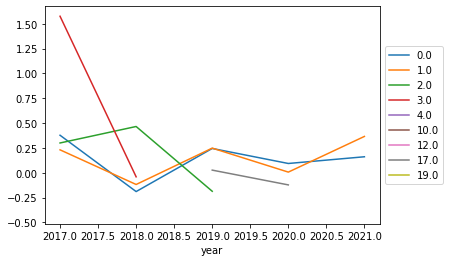

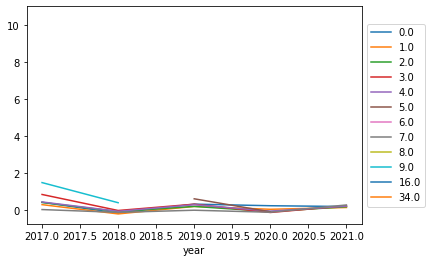

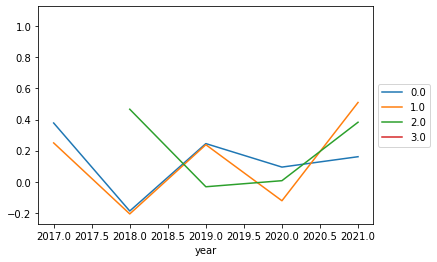

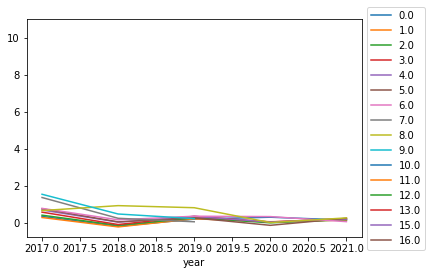

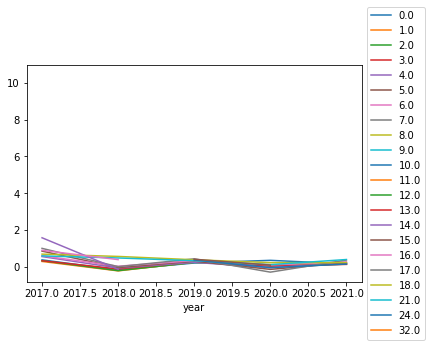

In [329]:
yearly_change_ratio_plot(filtered_df, 'ResultDividendPerShare1stQuarter/AdjustedClose')
yearly_change_ratio_plot(filtered_df, 'ResultDividendPerShare2ndQuarter/AdjustedClose')
yearly_change_ratio_plot(filtered_df, 'ResultDividendPerShare3rdQuarter/AdjustedClose')
yearly_change_ratio_plot(filtered_df, 'ResultDividendPerShareFiscalYearEnd/AdjustedClose')
yearly_change_ratio_plot(filtered_df, 'ResultDividendPerShareAnnual/AdjustedClose')


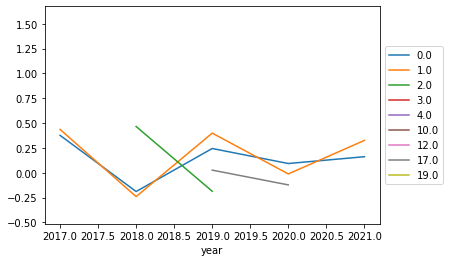

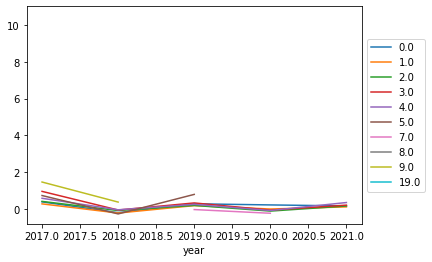

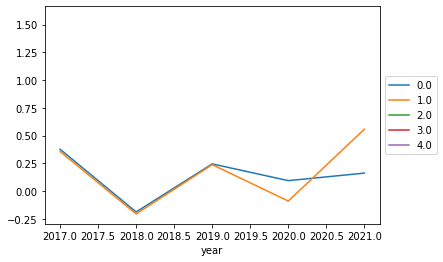

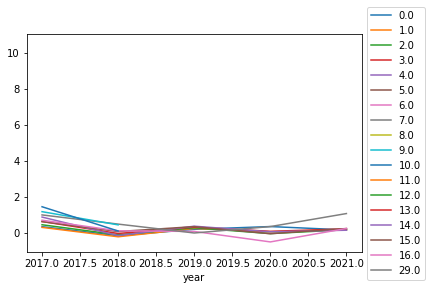

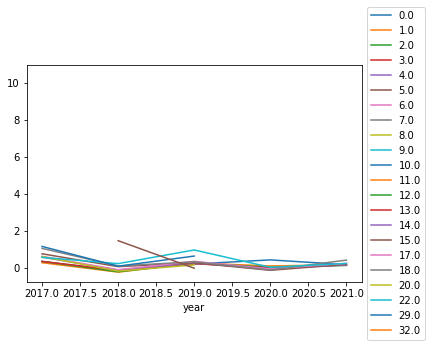

In [330]:
yearly_change_ratio_plot(filtered_df, 'ForecastDividendPerShare1stQuarter/AdjustedClose')
yearly_change_ratio_plot(filtered_df, 'ForecastDividendPerShare2ndQuarter/AdjustedClose')
yearly_change_ratio_plot(filtered_df, 'ForecastDividendPerShare3rdQuarter/AdjustedClose')
yearly_change_ratio_plot(filtered_df, 'ForecastDividendPerShareFiscalYearEnd/AdjustedClose')
yearly_change_ratio_plot(filtered_df, 'ForecastDividendPerShareAnnual/AdjustedClose')

In [ ]:
X.columns